In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !cp '/content/drive/MyDrive/VU Amsterdam/Year 3/Machine Learning/MLProject/src/data.zip' .
# !unzip data.zip

In [3]:
!pip install -q -U keras-tuner
import keras_tuner as kt
from keras import backend as K

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from numba import cuda

In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [6]:
def getData():

    dir = 'data/'

    df = pd.read_csv(dir + 'labels.csv')

    df['path'] = df['path'].str.replace('\\', os.sep)

    return df

In [7]:
df = getData()

train_df = df.loc[(df['is_validation'] == 0) & (df['is_final_validation'] == 0)]
valid_df =df.loc[df['is_validation'] == 1]
test_df = df.loc[df['is_final_validation'] == 1 ]

train_cleaned_df = pd.concat( [train_df.loc[train_df['is_bee'] == 1], train_df.loc[train_df['is_wasp'] == 1] ])
valid_cleaned_df = pd.concat( [valid_df.loc[valid_df['is_bee'] == 1], valid_df.loc[valid_df['is_wasp'] == 1] ])

gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train = gen.flow_from_dataframe(train_cleaned_df, directory= 'data/', x_col='path', y_col='label', target_size=(256,256), class_mode="binary")
valid = gen.flow_from_dataframe(valid_cleaned_df, directory= 'data/', x_col='path', y_col='label', target_size=(256,256), class_mode="binary")


Found 5635 validated image filenames belonging to 2 classes.
Found 1234 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  import sys


In [8]:
def model_builder(hp):
  K.clear_session()

  model = Sequential()

  #layer 1
  hp_units = hp.Int('units', min_value=32, max_value=128, step=32)
  model.add(Conv2D(hp_units, (3,3), padding= 'same', activation='relu', input_shape=(256,256,3)))
  model.add(Conv2D(hp_units, (3,3), padding= 'same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(3))
  hp_dropout = hp.Float('rate', min_value=0.0, max_value=0.5, step=0.1)
  model.add(Dropout(hp_dropout))

  #layer 2
  hp_units2 = hp.Int('units2', min_value=64, max_value=256, step=32)
  model.add(Conv2D(hp_units2, (3,3), padding= 'same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(3))
  hp_dropout2 = hp.Float('rate2', min_value=0.0, max_value=0.5, step=0.1)
  model.add(Dropout(hp_dropout2))

  #layer 3
  hp_units3 = hp.Int('units3', min_value=128, max_value=512, step=32)
  model.add(Conv2D(hp_units3, (3,3), padding= 'same', activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(3))
  hp_dropout3 = hp.Float('rate3', min_value=0.0, max_value=0.5, step=0.1)
  model.add(Dropout(hp_dropout3))

  #layer 4
  model.add(Flatten())
  hp_units4 = hp.Int('units4', min_value=256, max_value=512, step=32)
  model.add(Dense(hp_units4, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001))) 
  hp_dropout4 = hp.Float('rate4', min_value=0.0, max_value=0.5, step=0.1)
  model.add(Dropout(hp_dropout4))

  model.add(Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  optimizer = Adam(learning_rate=hp_learning_rate)
  
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [9]:
!rm -R tuner

In [10]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=15,
                     factor=3,
                     directory='tuner',
                     project_name='ML Project CNN')

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", patience = 5)

tuner.search(train, epochs=25, batch_size=8, validation_data=valid, callbacks=[earlystopping])

Trial 30 Complete [00h 07m 16s]
val_accuracy: 0.8411669135093689

Best val_accuracy So Far: 0.8946515321731567
Total elapsed time: 01h 26m 56s
INFO:tensorflow:Oracle triggered exit


In [11]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [12]:
tuner.results_summary()

Results summary
Results in tuner/ML Project CNN
Showing 10 best trials
Trial summary
Hyperparameters:
units: 32
rate: 0.4
units2: 224
rate2: 0.1
units3: 160
rate3: 0.5
units4: 352
rate4: 0.0
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8946515321731567
Trial summary
Hyperparameters:
units: 96
rate: 0.1
units2: 160
rate2: 0.30000000000000004
units3: 416
rate3: 0.1
units4: 384
rate4: 0.2
learning_rate: 0.0001
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.8776336908340454
Trial summary
Hyperparameters:
units: 32
rate: 0.1
units2: 224
rate2: 0.5
units3: 256
rate3: 0.2
units4: 480
rate4: 0.5
learning_rate: 0.0001
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 0.8711507320404053
Trial summary
Hyperparameters:
units: 96
rate: 0.1
units2: 96
rate2: 0.2
units3: 416
rate3: 0.1
units4: 416
rate4: 0.4
learning_rate: 0.001
tuner/epochs

In [13]:
tuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.001,
 'rate': 0.4,
 'rate2': 0.1,
 'rate3': 0.5,
 'rate4': 0.0,
 'tuner/bracket': 0,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units': 32,
 'units2': 224,
 'units3': 160,
 'units4': 352}

In [14]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 224)       6

In [15]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train, batch_size=32, epochs=50, validation_data=valid)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
177/177 [==============================] - 27s 147ms/step - loss: 1.8152 - accuracy: 0.7659 - val_loss: 10.7235 - val_accuracy: 0.6078
Epoch 2/50
177/177 [==============================] - 26s 147ms/step - loss: 1.1499 - accuracy: 0.8380 - val_loss: 8.3748 - val_accuracy: 0.6078
Epoch 3/50
177/177 [==============================] - 26s 148ms/step - loss: 0.9688 - accuracy: 0.8545 - val_loss: 3.1239 - val_accuracy: 0.6929
Epoch 4/50
177/177 [==============================] - 26s 147ms/step - loss: 0.8791 - accuracy: 0.8614 - val_loss: 0.9459 - val_accuracy: 0.8217
Epoch 5/50
177/177 [==============================] - 26s 148ms/step - loss: 0.7659 - accuracy: 0.8703 - val_loss: 1.0217 - val_accuracy: 0.8104
Epoch 6/50
177/177 [==============================] - 26s 147ms/step - loss: 0.6790 - accuracy: 0.8827 - val_loss: 0.7652 - val_accuracy: 0.8663
Epoch 7/50
177/177 [==============================] - 26s 146ms/step - loss: 0.6744 - accuracy: 0.8729 - val_loss: 0.9737 - val_a

In [16]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
final_h = hypermodel.fit(train, batch_size=32, epochs=best_epoch, validation_data=valid)

Epoch 1/49
177/177 [==============================] - 27s 148ms/step - loss: 2.1729 - accuracy: 0.7042 - val_loss: 6.4181 - val_accuracy: 0.6078
Epoch 2/49
177/177 [==============================] - 26s 147ms/step - loss: 1.2560 - accuracy: 0.8158 - val_loss: 5.4530 - val_accuracy: 0.6078
Epoch 3/49
177/177 [==============================] - 26s 148ms/step - loss: 1.0678 - accuracy: 0.8488 - val_loss: 2.0184 - val_accuracy: 0.7115
Epoch 4/49
177/177 [==============================] - 26s 146ms/step - loss: 0.9325 - accuracy: 0.8529 - val_loss: 1.3560 - val_accuracy: 0.7131
Epoch 5/49
177/177 [==============================] - 26s 147ms/step - loss: 0.8138 - accuracy: 0.8681 - val_loss: 0.9392 - val_accuracy: 0.8412
Epoch 6/49
177/177 [==============================] - 26s 148ms/step - loss: 0.7402 - accuracy: 0.8674 - val_loss: 0.9511 - val_accuracy: 0.7812
Epoch 7/49
177/177 [==============================] - 26s 145ms/step - loss: 0.6997 - accuracy: 0.8768 - val_loss: 0.7629 - val_ac

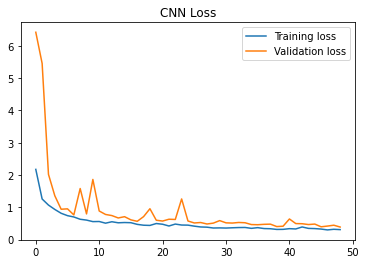

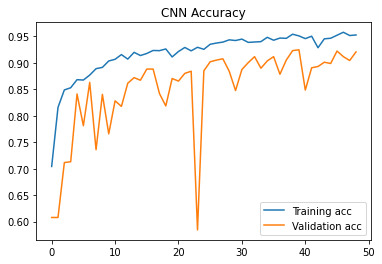

In [17]:
plt.title('CNN Loss')
plt.plot(final_h.epoch, final_h.history['loss'], label='Training loss')
plt.plot(final_h.epoch, final_h.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

plt.title('CNN Accuracy')
plt.plot(final_h.epoch, final_h.history['accuracy'], label='Training acc')
plt.plot(final_h.epoch, final_h.history['val_accuracy'], label='Validation acc')
plt.legend()
plt.show()


In [18]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 224)       6

In [20]:
hypermodel.save('hp_cnn_model')  # save the model
!zip -r hp_cnn_model.zip hp_cnn_model

INFO:tensorflow:Assets written to: hp_cnn_model/assets
  adding: hp_cnn_model/ (stored 0%)
  adding: hp_cnn_model/saved_model.pb (deflated 89%)
  adding: hp_cnn_model/keras_metadata.pb (deflated 93%)
  adding: hp_cnn_model/assets/ (stored 0%)
  adding: hp_cnn_model/variables/ (stored 0%)
  adding: hp_cnn_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: hp_cnn_model/variables/variables.index (deflated 71%)
